# Insurance (Project 6)

Iuliia Mozhina, 797609

### 1. Problem setting & data available

Given the customer and sales information, the task is to identify customers that could be interested in a caravan insurance and especially why. 

Import necessary libraries:

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from numpy import mean, interp
import seaborn as sns
import pandas as pd
import numpy as np

**Data:** The dataset contains 5822 observations with 85 features and a target variable (information of whether a customer has (1) or does not have (0) a caravan insurance policy). Each observation corresponds to a postal code.

In [2]:
data = pd.read_csv("data/caravan.train", delimiter = "\t", header=None)
# Rename column names according to the feature numbers:
new_cols_list = list(range(1, 87))
data.columns = new_cols_list

In [3]:
data

,1,2,3,4,5,6,7,8,9,10,...,77,78,79,80,81,82,83,84,85,86
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,1
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


A test set contains 4000 observations without the information on the caravan insurance policy.

In [4]:
test = pd.read_csv("data/caravan.test", delimiter = "\t",  header=None)
new_cols_list = list(range(1, 86))
test.columns = new_cols_list

In [5]:
test

,1,2,3,4,5,6,7,8,9,10,...,76,77,78,79,80,81,82,83,84,85
0,33,1,4,2,8,0,6,0,3,5,...,0,0,0,0,1,0,0,0,0,0
1,6,1,3,2,2,0,5,0,4,5,...,2,0,0,0,1,0,0,0,0,0
2,39,1,3,3,9,1,4,2,3,5,...,1,0,0,0,1,0,0,0,0,0
3,9,1,2,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,31,1,2,4,7,0,2,0,7,9,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,33,1,2,4,8,0,7,2,0,5,...,0,0,0,0,1,0,0,0,0,0
3996,24,1,2,3,5,1,5,1,3,4,...,1,0,0,0,1,0,0,0,0,0
3997,36,1,2,3,8,1,5,1,3,7,...,0,0,0,0,1,0,0,0,1,0
3998,33,1,3,3,8,1,4,2,3,7,...,0,0,0,0,0,0,0,0,0,0


### 2. Data exploration

2.1 Display some statistical properties

In [11]:
data.describe()

,1,2,3,4,5,6,7,8,9,10,...,77,78,79,80,81,82,83,84,85,86
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,...,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256,0.059773
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,...,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996,0.237087
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,10.000000,5.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000


2.2 Check the quantity of data for each class...

In [12]:
data[86].value_counts()

0    5474
1     348
Name: 86, dtype: int64

In [13]:
print("Only {}% of all customers bought a caravan insurance.".format(data[86].value_counts()[1] / len(data) * 100))

Only 5.977327378907591% of all customers bought a caravan insurance.


...and visualize it

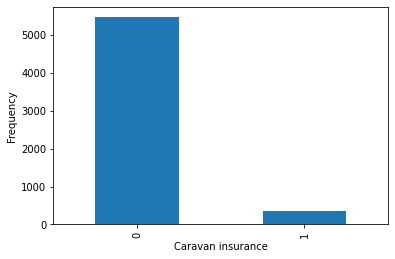

In [14]:
fig, ax = plt.subplots()
data[86].value_counts().plot(ax=ax, kind='bar', xlabel='Caravan insurance', ylabel='Frequency')
plt.show()

--> **the dataset is inbalanced**, since it contains too few examples for CARAVAN = 1

2.3 Check for missing values:

In [15]:
print(data.count().sum())
print(data.notnull().values.sum())

500692
500692


--> **the dataset does not contain missing values**

### 3. Training and evaluating the baseline model (Decision Tree)

In [6]:
features = data.loc[:, data.columns != 86]
target = data.loc[:, data.columns == 86]
X = features.values
y = target.values
print(X.shape, y.shape)

(5822, 85) (5822, 1)


Define a nested cross validation procedure: 

In [24]:
def nested_CV(X, y, p_grid, model):
    # configure the outer loop of the cross-validation procedure for model evaluation 
    cv_outer = KFold(n_splits=4, shuffle=True, random_state=1)
 
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    i = 1

    for train_ix, test_ix in cv_outer.split(X):
        # split data in train and test sets for model training and evaluation 
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y.ravel()[train_ix], y.ravel()[test_ix]
    
        # configure the inner loop of the cross-validation procedure for parameter tuning
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    
        # iterate over all values of lambda in the parameter space
        search = GridSearchCV(model, p_grid, scoring="roc_auc", cv=cv_inner, refit=True)
    
        # execute search of the hyper parameters by fitting the model on each train set
        # and tune (hyper)parameters on each validation sets
        result = search.fit(X_train, y_train)
        
        # return the parameter setting that gave the best estimate on the hold out data
        print("Best parameter setting found for fold {}:".format(i))
        print(result.best_params_)
    
        probas_ = result.predict_proba(X_test)
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        print("with an estimate on the holdout test set:", roc_auc)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)   # the averaged estimate of the generalization erroron the hold out test set
    print("Average AUC on the holdout test set", mean_auc)   # basically our empirical risk 
    plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean (AUC = %0.4f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) with cross validation')
    plt.legend(loc="lower right")
    plt.show()

Training a Decision Tree classifier using nested cross validation:

Best parameter setting found for fold 1:
{'criterion': 'log_loss', 'max_depth': 5}
with an estimate on the holdout test set: 0.7448424433348835
Best parameter setting found for fold 2:
{'criterion': 'log_loss', 'max_depth': 3}
with an estimate on the holdout test set: 0.7443731806025606
Best parameter setting found for fold 3:
{'criterion': 'gini', 'max_depth': 3}
with an estimate on the holdout test set: 0.7452258717780186
Best parameter setting found for fold 4:
{'criterion': 'gini', 'max_depth': 3}
with an estimate on the holdout test set: 0.7521489621489621
Average AUC on the holdout test set 0.74660330970635


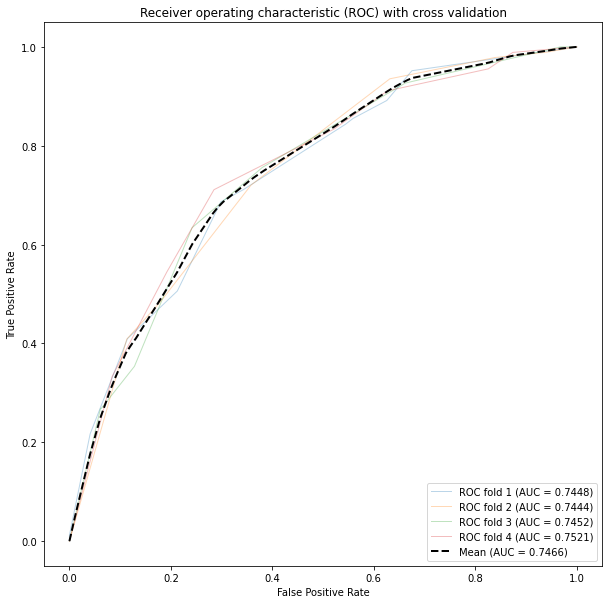

In [25]:
# define a decision tree model
model = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# Set up possible values of parameters to optimize over
p_grid = {"max_depth": [3, 5, 10, 20, 50],
          "criterion": ["gini", "log_loss", "entropy"] }

nested_CV(X, y, p_grid, model)

AUC of the baseline Decision tree classifier: **0.7466**

with the averaged hyper parameters: {'criterion': 'gini', 'max_depth': 3}

Train a final model with these parameter values on the whole dataset:

In [7]:
decision_tree = DecisionTreeClassifier(random_state=1, class_weight="balanced",
                                               criterion="gini", max_depth=3)
decision_tree.fit(X, y.ravel())

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=1)

### 4. Random Forest

Best parameter setting found for fold 1:
{'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 100}
with an estimate on the holdout test set: 0.7404724506182048
Best parameter setting found for fold 2:
{'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 100}
with an estimate on the holdout test set: 0.7949691935089422
Best parameter setting found for fold 3:
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 1000}
with an estimate on the holdout test set: 0.7347538770362212
Best parameter setting found for fold 4:
{'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 100}
with an estimate on the holdout test set: 0.7535327635327634
Average AUC on the holdout test set 0.7559509621347847


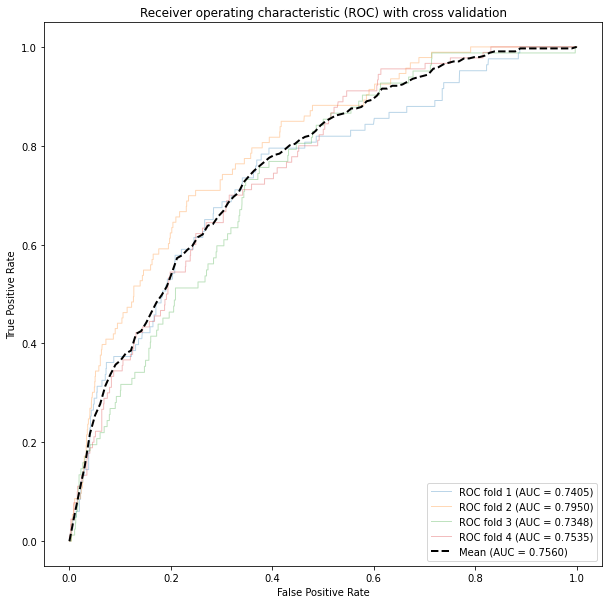

In [17]:
# define a random forest model
model = RandomForestClassifier(random_state=1, class_weight="balanced")

# Set up possible values of parameters to optimize over
p_grid = {"n_estimators": [100, 500, 1000], "max_depth": [3, 5, 10, 20, 50],
          "criterion": ["gini", "log_loss", "entropy"] }

nested_CV(X, y, p_grid, model)

AUC of the Random Forest classifier: **0.7560** (vs. 0.7466 of Decision Tree classifier)

with the averaged hyper parameters: {'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 325}

Train a final model with these parameter values on the whole dataset:

In [8]:
random_forest = RandomForestClassifier(random_state=1, class_weight="balanced",
                                               criterion="log_loss", n_estimators=325, max_depth=5)
random_forest.fit(X, y.ravel())

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=5, n_estimators=325, random_state=1)

Look at the importance of individual features for the Random Forest classifier:

In [29]:
feature_importance = np.array(random_forest.feature_importances_)
feature_names = np.array(features.columns)
importances={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(importances)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi_df = fi_df.astype(str)

In [30]:
fi_df.head(10)

,feature_names,feature_importance
46,47,0.15007731489015974
67,68,0.08772712369183683
58,59,0.0708724845100798
41,42,0.03376682603290966
43,44,0.03170914776619003
0,1,0.03161935070648953
36,37,0.03067573800816613
42,43,0.02710153642105789
17,18,0.026788158174733755
4,5,0.021255551554773707


In [31]:
fi_df.tail(10)

,feature_names,feature_importance
62,63,0.00022976415206598058
55,56,0.00018672706154291524
47,48,0.00017562939485827334
68,69,0.00017075543906956516
76,77,0.0001370307653753544
70,71,7.632877277830253e-18
49,50,0.0
59,60,0.0
73,74,0.0
52,53,0.0


### 4. Feature selection

**Motivation for the feature selection:**
1. Prevent overfitting
2. Explainable models
3. Variance reduction

Eliminate features which importance is smaller than a given threshold. The threshold here is the mean value of importance of all features.

In [9]:
threshold = random_forest.feature_importances_.mean()  # calculate the mean value of importance of all features
print("Mean value of importance of all features:", threshold)
sfm = SelectFromModel(random_forest, threshold=threshold)

important_features = features.columns[sfm.get_support()].union([86])   # add a target variable as well
print("Features selected by SelectFromModel:", important_features)
print("Number of features after selection:", len(important_features) - 1)

Mean value of importance of all features: 0.01176470588235294
Features selected by SelectFromModel: Int64Index([ 1,  5, 10, 12, 16, 18, 21, 22, 28, 29, 30, 31, 32, 34, 37, 39, 42,
            43, 44, 47, 54, 59, 61, 65, 68, 80, 86],
           dtype='int64')
Number of features after selection: 26


In [10]:
data_reduced = data[data.columns.intersection(important_features)]
data_reduced

,1,5,10,12,16,18,21,22,28,29,...,43,44,47,54,59,61,65,68,80,86
0,33,8,7,2,1,7,1,2,6,1,...,3,0,6,0,5,0,0,1,1,0
1,37,8,6,2,0,4,0,5,5,0,...,4,2,0,0,2,0,2,0,1,0
2,37,8,3,4,0,4,0,7,4,0,...,4,2,6,0,2,0,1,1,1,0
3,9,3,5,2,3,2,0,3,4,0,...,4,0,6,0,2,0,0,1,1,0
4,40,10,7,2,5,0,4,0,0,0,...,3,0,0,0,6,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,8,1,6,2,2,0,4,3,0,...,3,2,6,0,3,0,1,1,1,0
5818,35,8,6,3,0,9,1,3,0,0,...,5,0,0,3,5,0,0,0,1,0
5819,33,8,5,4,0,8,0,2,4,4,...,3,2,6,0,4,0,1,1,1,1
5820,34,8,7,0,0,7,0,2,5,0,...,6,0,6,0,0,0,0,1,0,0


Train a Random Forest classifier using the most important features only:

In [11]:
features = data_reduced.loc[:, data_reduced.columns != 86]
target = data_reduced.loc[:, data_reduced.columns == 86]
X = features.values
y = target.values
print(X.shape, y.shape)

(5822, 26) (5822, 1)


Best parameter setting found for fold 1:
{'criterion': 'log_loss', 'max_depth': 3, 'n_estimators': 1000}
with an estimate on the holdout test set: 0.7436183188690669
Best parameter setting found for fold 2:
{'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 100}
with an estimate on the holdout test set: 0.7935018420782746
Best parameter setting found for fold 3:
{'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 1000}
with an estimate on the holdout test set: 0.7628213099319631
Best parameter setting found for fold 4:
{'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 1000}
with an estimate on the holdout test set: 0.7675213675213676
Average AUC on the holdout test set 0.7668698631348674


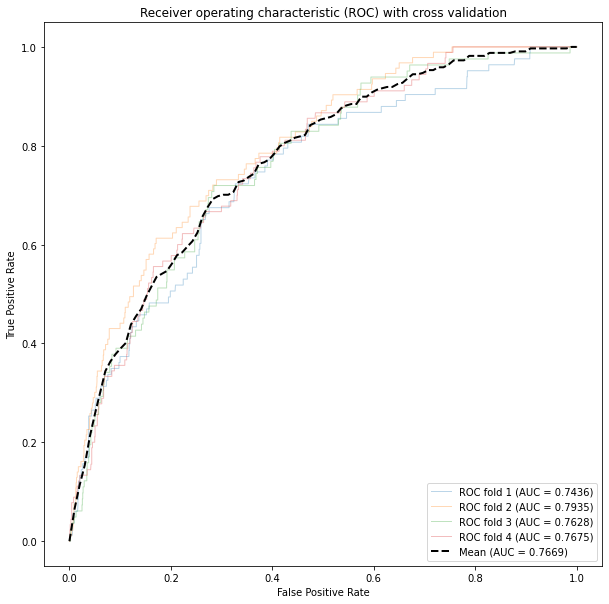

In [111]:
# define a random forest model
model = RandomForestClassifier(random_state=1, class_weight="balanced")

# Set up possible values of parameters to optimize over
p_grid = {"n_estimators": [100, 500, 1000], "max_depth": [3, 5, 10],
          "criterion": ["gini", "log_loss"] }

nested_CV(X, y, p_grid, model)

AUC of the Random Forest classifier with 26 most important features: **0.7669** (vs. 0.7560 of Random Forest with all features)

with the averaged hyper parameters: {'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 775}

Train a final model with these parameter values on the whole dataset:

In [12]:
random_forest_reduced = RandomForestClassifier(random_state=1, class_weight="balanced",
                                               criterion="log_loss", n_estimators=775, max_depth=6)
random_forest_reduced.fit(X, y.ravel())

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=6, n_estimators=775, random_state=1)

### 5. Apply the Random Forest Classifier with reduced amount of features to the test data

In [ ]:
# drop the same features from test data before predicting results
test_reduced = test[test.columns.intersection(important_features)]

X_test = test_reduced.values
y_pred = random_forest_reduced.predict(X_test)
test_reduced['CARAVAN'] = y_pred

Identify customers that will buy the Caravan insurance:

In [39]:
buyers = test_reduced.loc[test_reduced['CARAVAN'] == 1] 
buyers

,1,5,10,12,16,18,21,22,28,29,...,43,44,47,54,59,61,65,68,80,CARAVAN
1,6,2,5,2,5,0,0,4,2,1,...,8,2,6,0,4,0,1,1,1,1
2,39,9,5,3,2,4,1,3,2,1,...,5,2,6,0,4,0,1,1,1,1
11,36,8,8,1,1,4,0,4,4,0,...,3,2,6,0,0,0,1,2,0,1
17,39,9,9,0,0,5,0,3,5,0,...,5,2,6,0,4,0,1,1,1,1
20,33,8,3,4,0,4,0,7,4,0,...,3,0,6,0,4,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,10,3,7,1,2,3,0,3,3,0,...,8,0,6,0,0,0,0,1,0,1
3995,33,8,5,2,0,6,0,1,4,2,...,3,2,6,0,3,0,1,1,1,1
3996,24,5,4,4,2,4,0,3,5,1,...,2,0,6,0,4,0,0,1,1,1
3997,36,8,7,2,2,4,0,3,5,0,...,3,0,6,0,3,0,0,1,1,1


Display the feature importances of the Random Forest classifier with the reduced number of attributes:

In [41]:
feature_importance = np.array(random_forest_reduced.feature_importances_)
feature_names = np.array(features.columns)
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

In [42]:
top_10_features = fi_df['feature_names'].tolist()[:10]

In [43]:
fi_df.head(10)  # display top 10 important features

,feature_names,feature_importance
19,47,0.173984
24,68,0.093397
21,59,0.083437
0,1,0.053579
14,37,0.043890
5,18,0.042281
16,42,0.040864
7,22,0.034535
17,43,0.034484
2,10,0.033893


**47** PPERSAUT Contribution car policies <br />
**68** APERSAUT Number of car policies <br />
**59** PBRAND Contribution fire policies <br />
**1** MOSTYPE Customer Subtype see L0 <br />
**37** MINKM30 Income < 30.000 <br />
**18** MOPLLAAG Lower level education <br />
**42** MINKGEM Average income <br />
**22** MBERMIDD Middle management <br />
**43** MKOOPKLA Purchasing power class <br />
**10** MRELGE Married <br />

Display top 10 features only for better interpretation:

In [45]:
buyers[buyers.columns.intersection(top_10_features)]  

,1,10,18,22,37,42,43,47,59,68
1,6,5,0,4,1,6,8,6,4,1
2,39,5,4,3,2,3,5,6,4,1
11,36,8,4,4,2,5,3,6,0,2
17,39,9,5,3,6,3,5,6,4,1
20,33,3,4,7,4,3,3,6,4,1
...,...,...,...,...,...,...,...,...,...,...
3994,10,7,3,3,0,4,8,6,0,1
3995,33,5,6,1,3,2,3,6,3,1
3996,24,4,4,3,3,4,2,6,4,1
3997,36,7,4,3,2,4,3,6,3,1


Investigate the contribution (PPERSAUT) and number (APERSAUT) of car policies of customers:

/var/folders/7t/sd7xvs6s3n3d4rf0gsmsks6r0000gn/T/ipykernel_18883/76933754.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  car_policy.hist(ax = ax)


array([[<AxesSubplot:title={'center':'47'}>,
        <AxesSubplot:title={'center':'68'}>]], dtype=object)

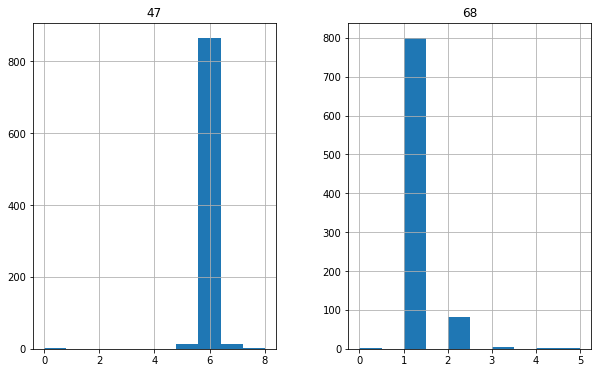

In [46]:
car_policy = buyers[[47,68]]

fig = plt.figure(figsize = (10,6))
ax = fig.gca()
car_policy.hist(ax = ax)

--> most of the buyers have at least 1 car insurance and annualy pay 1000 - 4999 USD for it. People without a car will very unlikely buy a caravan insurance.

Investigate the contribution of fire policy (PBRAND)

array([<AxesSubplot:title={'center':'59'}>], dtype=object)

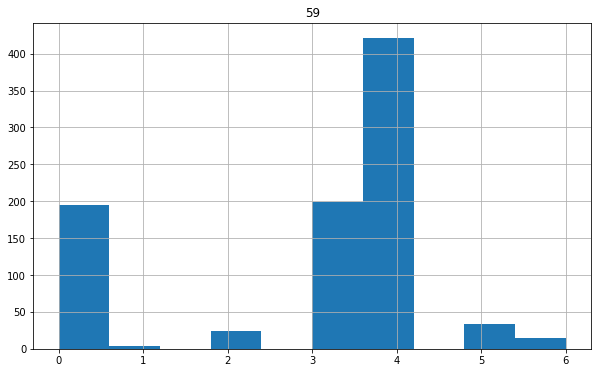

In [48]:
fire_policy = buyers[[59]]

fig = plt.figure(figsize = (10,6))
ax = fig.gca()
fire_policy.hist(ax = ax)

--> a large group of buyers spend 100 - 499 USD a year for a fire insurance, while some buyers don't have a fire insurance at all.

Investigate the customer subtype (MOSTYPE):

array([<AxesSubplot:title={'center':'1'}>], dtype=object)

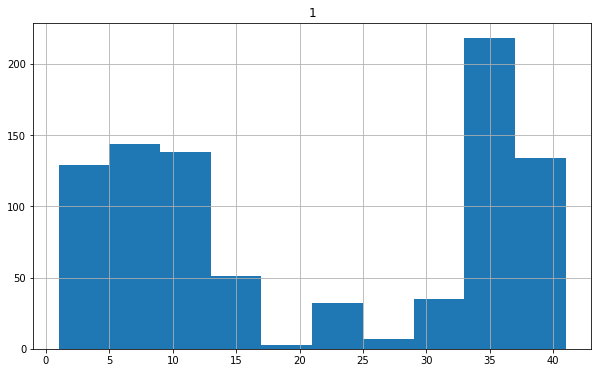

In [49]:
customer_subtype = buyers[[1]]

fig = plt.figure(figsize = (10,6))
ax = fig.gca()
customer_subtype.hist(ax = ax)

Families with kids will most likely buy a caravan insurance, while the students and young people will probably not interested in this purchase. Surprisingly, seniors are unlikely to buy a caravan insurance.


Investigate the purchasing power class (MKOOPKLA):

array([<AxesSubplot:title={'center':'43'}>], dtype=object)

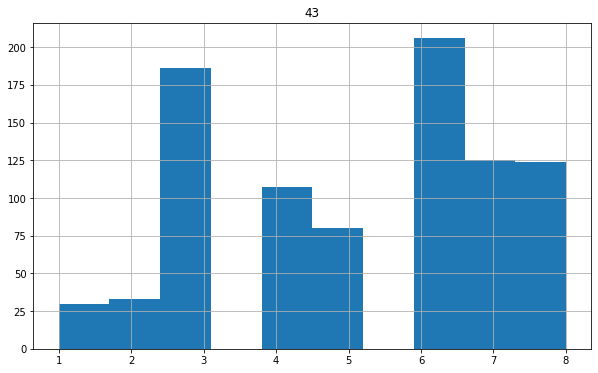

In [50]:
purch_power = buyers[[43]]

fig = plt.figure(figsize = (10,6))
ax = fig.gca()
purch_power.hist(ax = ax)

--> inconsistent results. The likelihood of buying a caravan insurance is low for very low purchasing power classes (1-23%), likelihood is high for the 24-36% class. At very high purchasing power levels, the likelihood of buying a caravan insurance drops again. Further investigation needed. 